In [1]:
import pandas as pd
import numpy as np
import PIL
from PIL import Image
import os
import splitfolders
import imagesize
import cv2
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib
import seaborn as sns
from datafunc import plot_example, min_max_dimensions, reshape, dimensions_distributions, plot_dim_dist, avg_image

## Data

In [2]:
datapath='../0. Project Data/Original Data'
org_data_dir = pathlib.Path(datapath).with_suffix('')
org_data_dir

WindowsPath('../0. Project Data/Original Data')

#### Loading Data

In [3]:
Blight_Count = len(list(org_data_dir.glob('Blight/*.jpg')))
Common_Rust_Count = len(list(org_data_dir.glob('Common_Rust/*.jpg')))
Gray_Leaf_Spot_Count = len(list(org_data_dir.glob('Gray_Leaf_Spot/*.jpg')))
Healthy_Count = len(list(org_data_dir.glob('Healthy/*.jpg')))
print('Blight images:', Blight_Count)
print('Common Rust images:', Common_Rust_Count)
print('Gray Leaf Spot images:', Gray_Leaf_Spot_Count)
print('Healthy images:', Healthy_Count)
print('Total images:', Blight_Count + Common_Rust_Count + Gray_Leaf_Spot_Count + Healthy_Count)

Blight images: 1146
Common Rust images: 1306
Gray Leaf Spot images: 574
Healthy images: 1162
Total images: 4188


#### Example Images

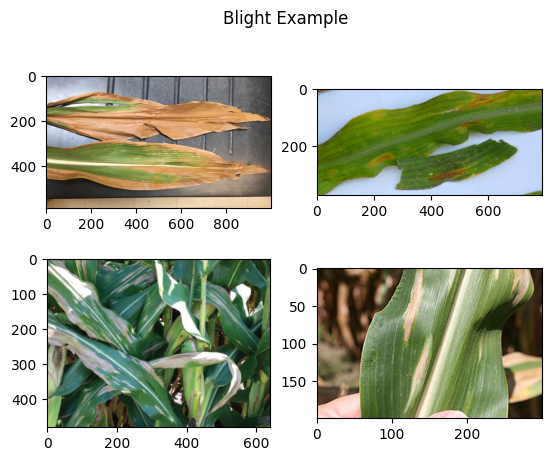

In [4]:
plot_example('Blight', org_data_dir)

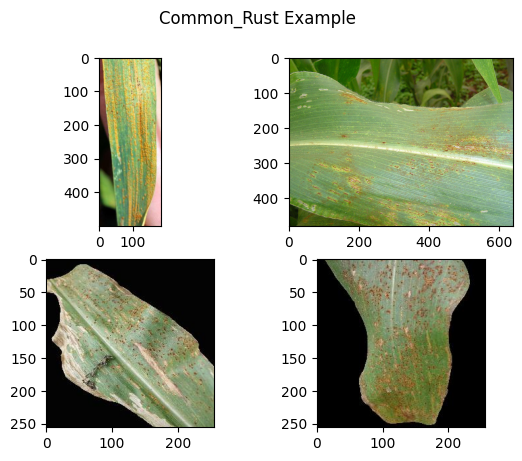

In [5]:
plot_example('Common_Rust', org_data_dir)

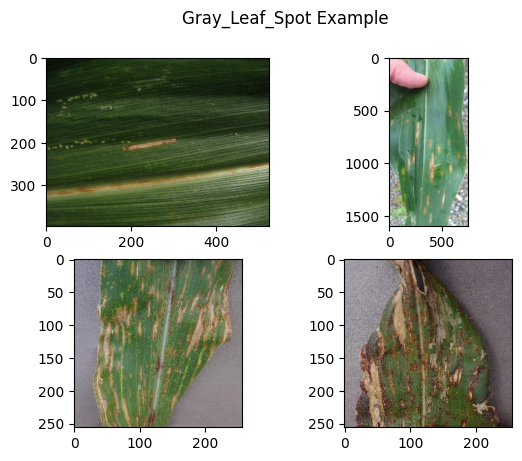

In [6]:
plot_example('Gray_Leaf_Spot', org_data_dir)

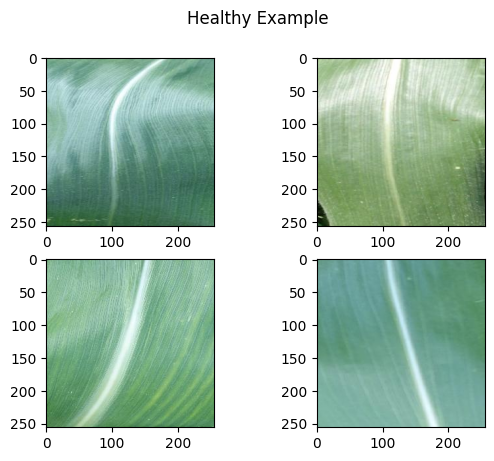

In [7]:
plot_example('Healthy', org_data_dir)

#### Checking Minimum and Maximum Image Dimensions

In [8]:
dims = min_max_dimensions(org_data_dir)
print( 'max dimensions', dims[0])
print( 'min dimensions', dims[1])

max dimensions (5184, 5184)
min dimensions (180, 116)


### Checking Distribution of Image Height and Image Width

In [9]:
widths, heights = dimensions_distributions(org_data_dir)

#### Widths

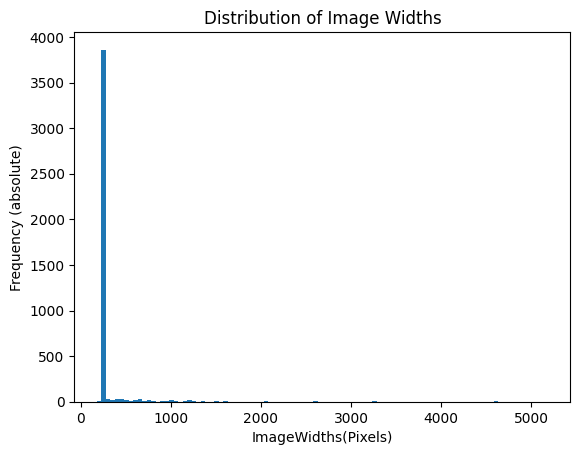

In [10]:
plot_dim_dist(widths, bins=100, dim ='Widths')

#### Zoomed in Widths

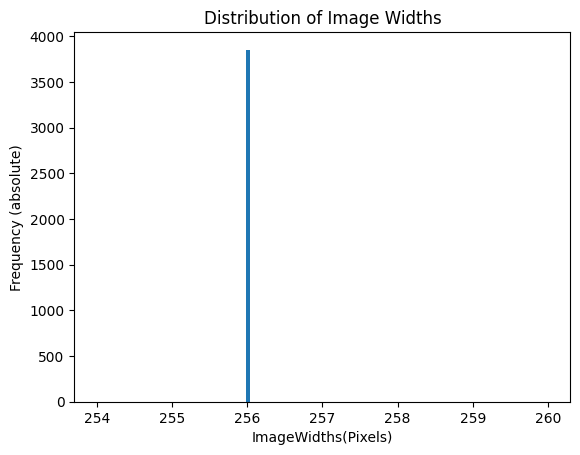

In [11]:
plot_dim_dist(widths, bins=100, dim ='Widths', range_ = (254,260))

#### Widths Value Counts

In [12]:
Width_series= pd.Series(widths, name = 'width')
Width_series.value_counts(ascending=False).head()

width
256     3853
1024      17
400       17
432       14
1200      13
Name: count, dtype: int64

#### Percentage of Width Values Below 256

In [13]:
(Width_series <= 256).mean()

0.9228748806112703

It seems like ~ 92.3% of images have a width of 256 pixels or less

#### Heights

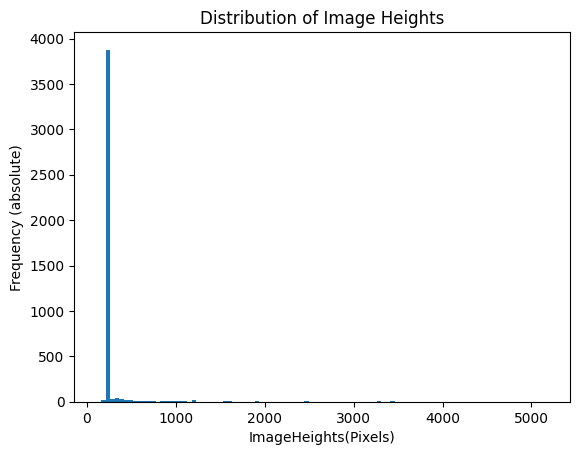

In [14]:
plot_dim_dist(heights, bins=100, dim ='Heights')

#### Zoomed in Heights

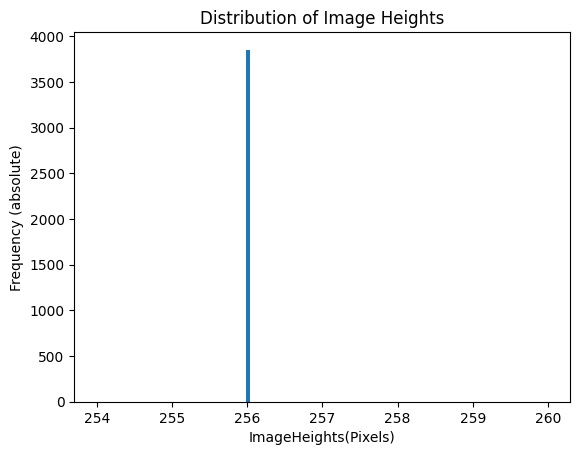

In [15]:
plot_dim_dist(heights, bins=100, dim ='Heights', range_ = (254,260))

#### Heights Value Counts

In [16]:
Height_series= pd.Series(heights, name='height')
Height_series.value_counts(ascending=False).head()

height
256     3852
1200      14
350       10
2448       8
768        8
Name: count, dtype: int64

#### Percentage of Height Values Below 256

In [17]:
(Height_series <= 256).mean()

0.9266953199617957

It seems like ~ 92.7% of images have a height of 256 pixels or less

#### How many images are square?

In [18]:
df=pd.concat([Width_series,Height_series],axis=1)
df['square']= [1 if row[0]==row[1]  else 0 for index, row in df.iterrows()]
df['height & width 256']= [1 if row[0]==256 and row[1] == 256 else 0 for index, row in df.iterrows()]
df.head()

,width,height,square,height & width 256
0,1000,585,0,0
1,788,371,0,0
2,641,482,0,0
3,300,200,0,0
4,256,256,1,1


In [19]:
df.square.mean()

0.9214422158548233

~ 92.1% of images have square dimensions

In [20]:
df['height & width 256'].mean()

0.9197707736389685

~ 92.0% of images have a height and width equal to 256 pixels

In [21]:
df_sub=df[df['height & width 256']==0]

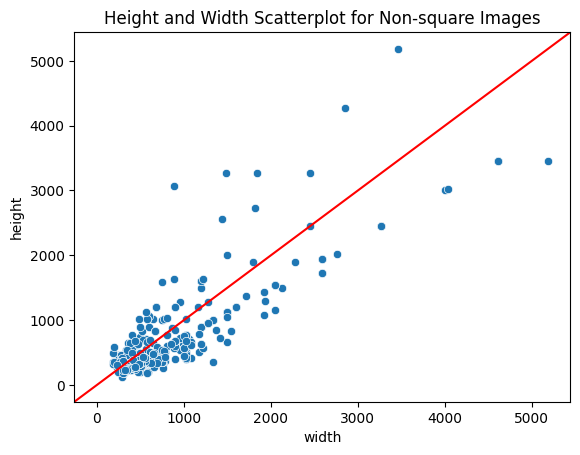

In [22]:
sns.scatterplot(data=df_sub, x='width', y= 'height')
plt.axline([0, 0], [1, 1], color='red')
plt.title('Height and Width Scatterplot for Non-square Images');
plt.show()

Conclusion: most images are square and have dimensions 256 x 256. Most other images are near-square as shown by the clumpings near the 45° line. This lets us conclude that an input image size of 256 x 256 would have the least impact as most images are already at this resolution or are near-square.

#### Image Resizing

We can see that input images have varying width and height dimensions. However, Covolutional Neural Networks (CNN) require that input images all be of the same size in order for the matrix math to work correctly. There are several options to satisfy these requirements although some may have negative effects on training.

• **Cropping**

Cropping images means selecting a window size and centering it around the most important parts of the image. This introduces some new problems: deciding what part of the image is most important as well as the fact that certain border pixels are going to be removed resulting in potential loss of information. In addition, the wide variety of image dimensions (116 pixels to 5184 pixels) means a cropping widow for one image might not work as well for another image.
    
• **Stretching**

Stretching images means stretching or squashing the image to reach the desired dimensions. This results in less loss of information than cropping but features may be distorted. If the image is squashed, some information is loss due to the reduction in granularity. For both stretching and squashing, the relative spatial orientation of pixels becomes distorted which could interfere with the CNN's ability to isolate important features.
    
• **Zero-padding**

Zero-padding is our last solution and keeps original image aspect ratio. In order to convert each image to the same size, images are first upscaled or downscaled until the longest dimension is 256 pixels (or whatever you choose) while maintaining the aspect ratio. Pixels of 0's are then filled around the shorter side's border to make the resulting image square. A 2019 [study](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-019-0263-7) showed that "zero-padding had no effect on the classification accuracy but considerably reduced the training time. The reason is that neighboring zero input units (pixels) will not activate their corresponding convolutional unit in the next layer. Therefore, the synaptic weights on outgoing links from input units do not need to be updated if they contain a zero value."


**Zero-padding** seems like the best solution

#### Zero-padding

First upscaled or downscale images while maintaining aspect ratio

In [23]:
dim = 256 # length of desired image height and width
reshaped_dir = '../0. Project Data/Reshaped Data/'
for directory in ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']:
    for index, image_dir in enumerate(org_data_dir.glob(directory+'/*.jpg')):
        image = cv2.imread(str(image_dir))
        width, height = imagesize.get(image_dir)
        aspect_ratio = width / height
        save_path = reshaped_dir + directory + '/'
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        filename = directory + str(index) + '.jpg'
        #print(width, height, aspect_ratio)
        if width == dim and height == dim:
            #print('width and height equal 256')
            cv2.imwrite(save_path+filename, image)
            #(save image to new location, no padding needed)
        elif max(width, height) > dim:
            #downscale image using longest dimension
            if height >= width:
                desired_height = dim
                desired_width = int(dim * aspect_ratio)
                downscaled_image = cv2.resize(image, (desired_width, desired_height), interpolation=cv2.INTER_AREA)
            elif height < width:
                desired_width = dim
                desired_height = int(dim / aspect_ratio)
                downscaled_image = cv2.resize(image, (desired_width, desired_height), interpolation=cv2.INTER_AREA)
            cv2.imwrite(save_path+filename, downscaled_image)
            #save downscaled image
            #print('max(width, height) is greater than 256, scale larger dim down to 256')
            #interarea interplation, https://stackoverflow.com/questions/23853632/which-kind-of-interpolation-best-for-resizing-image
        elif max(width, height) < dim:
            #upscale image using longest dimension
            if height >= width:
                desired_height = dim
                desired_width = int(dim * aspect_ratio)
                upscaled_image = cv2.resize(image, (desired_width, desired_height), interpolation=cv2.INTER_CUBIC)
            elif height < width:
                desired_width = dim
                desired_height = int(dim / aspect_ratio) 
                upscaled_image = cv2.resize(image, (desired_width, desired_height), interpolation=cv2.INTER_CUBIC)
            cv2.imwrite(save_path+filename, upscaled_image)
            #save upscaled image
            #print('max(width, hieght) is less than 256, scale larger dim up to 256')
        #break
    #break

In [24]:
reshape_path='../0. Project Data/Reshaped Data'
reshape_data_dir = pathlib.Path(reshape_path).with_suffix('')
reshape_data_dir

WindowsPath('../0. Project Data/Reshaped Data')

Next, add the zero-padded pixels

In [25]:
padded_path = '../0. Project Data/Reshaped and zero-padded Data/'
for directory in ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']:
    for index, image_dir in enumerate(reshape_data_dir.glob(directory+'/*.jpg')):
        image = Image.open(image_dir)
        image = reshape(image, 256, 256, (0,0,0))
        image = image.convert('RGB')
        if not os.path.exists(padded_path+directory):
            os.makedirs(padded_path+directory)
        image.save(padded_path + directory + '/'+ directory + str(index) + '.jpg')

#### Split into Train/Validation/Test

In [26]:
train_split_test_dir='../0. Project Data/Reshaped zero-padded and split data'
splitfolders.ratio(padded_path, output=train_split_test_dir, seed=123, ratio=(.64, .16, .2)) # ratio of split are in order of train/val/test.

#### Example Image after Zero-padding

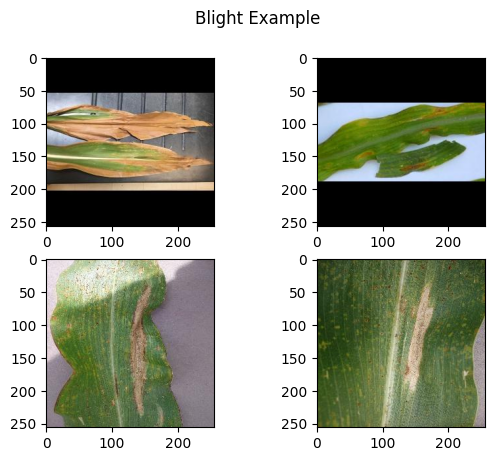

In [27]:
plot_example('Blight', pathlib.Path(padded_path).with_suffix(''))

#### Class RGB Image Averages

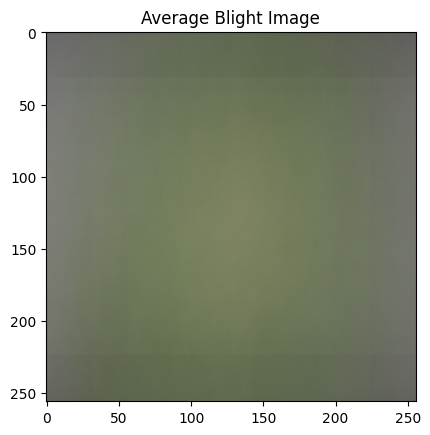

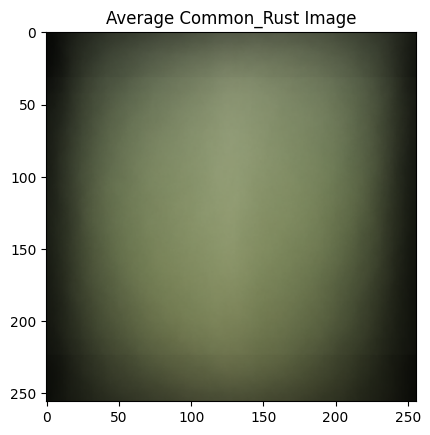

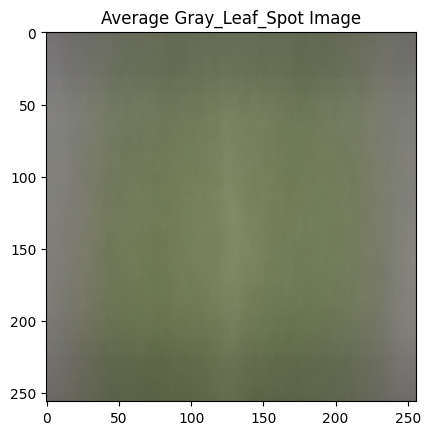

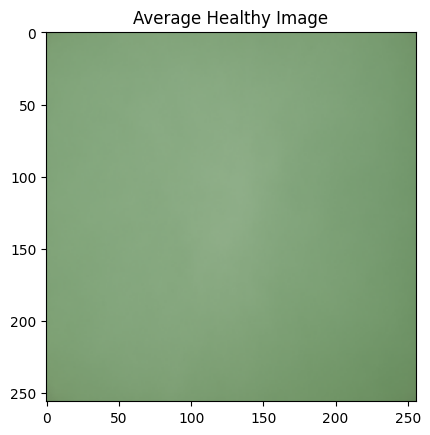

In [29]:
padded_dir = pathlib.Path(padded_path).with_suffix('')
for class_ in ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']:
    avg_image(class_, padded_dir)